robotiqGymEnv __init__
robot base reset
robot base reset


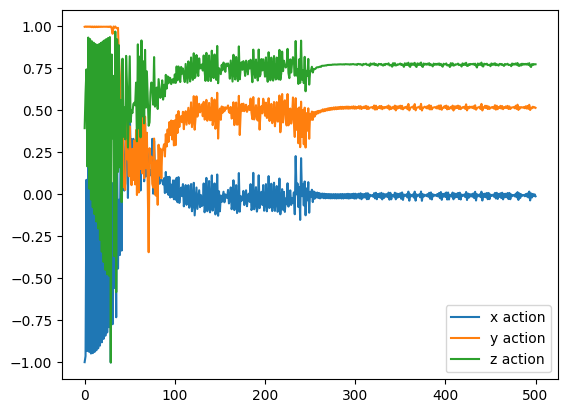

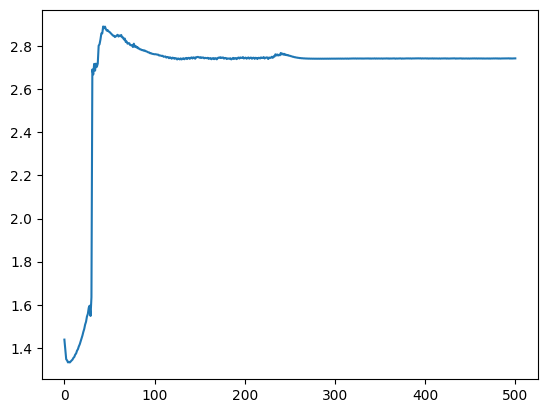

In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import gym
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

from stable_baselines3 import A2C, DDPG, PPO, TD3, SAC
# from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from robotiqGymEnv import robotiqGymEnv
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy


def main():

    env = robotiqGymEnv(records=False, renders=False, isDiscrete=False)

    dir = "models/20230206-02:22PM_SAC/best_model.zip"
    model = SAC.load(dir)

    # mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    # print(mean_reward)

    t_ = np.array([])
    rewards_ = np.array([])
    xaction_ = np.array([])
    yaction_ = np.array([])
    zaction_ = np.array([])

    dones = False
    obs = env.reset()

    while not dones:
        t_ = np.append(t_, env._envStepCounter)
        #   action = [0 , 0 , 0 , 0 , 0 , 0 , 0.1]
        # else:
        #   action = [0 , 0 , 0 , 1 , 0 , 1 , 1]
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, info = env.step(action)
        # plt.plot(env._robotiq.linkpos[0][0], env._robotiq.linkpos[0][1], 'ro')
        # plt.show()
        # env._robotiq.getjointstate()
        # print(env._action)
        # print(len(env._robotiq.linkpos))
        # print(env._contactinfo()[4])
        rewards_ = np.append(rewards_,env._reward())
        xaction_ = np.append(xaction_,action[0])
        yaction_ = np.append(yaction_,action[1])
        zaction_ = np.append(zaction_,action[2])
        # env.render()
        # time.sleep(0.1)
    plt.plot(xaction_, label="x action")
    plt.plot(yaction_, label="y action")
    plt.plot(zaction_, label="z action")
    plt.legend()

    plt.figure()
    plt.plot(rewards_, label="reward")
  



if __name__ == "__main__":
  main()